# **Are older players doing better more recently?**

Since the ascendancy and sustained success of Federer, Nadal, and Djokovic, it's seemed like the top players in tennis have skewed older. Let's try to evaluate this empirically. We'll look at this from a few perspectives:

- Elo ratings for all players by age, by year of first match. 
- Average Elo rating by age and year. 
- Average ATP ranking by age and year. 
- Average age for players that hit the top 10 by year. 

First, let's mount the google drive, import libraries we need, and connect to our SQL database. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pickle
with open('/content/drive/My Drive/ATP Tennis/Database/ATP_Pickle.pickle','rb') as f:
    atp_pickle = pickle.load(f)

First, we quickly plot the ages in the data once more. We see that most players are younger than 30 and ages are centered around 25-26. 

In [4]:
matches = atp_pickle[0]

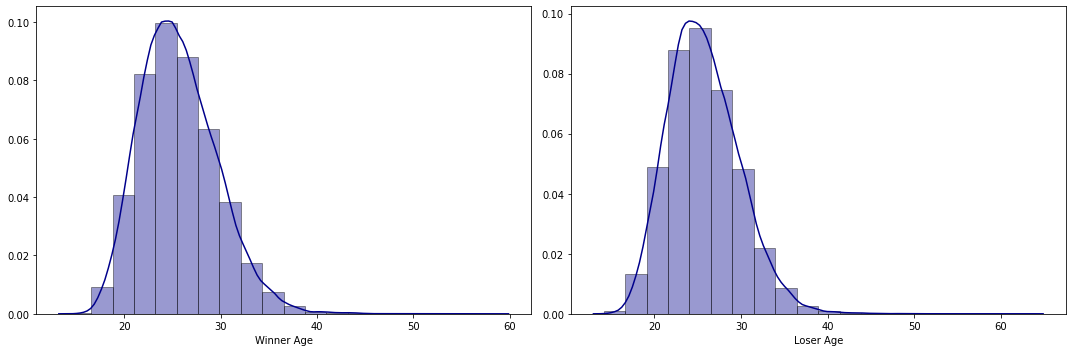

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(matches["winner_age"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Winner Age")

plt.subplot(1, 2, 2)
sns.distplot(matches["loser_age"], hist=True, kde=True, 
             bins=20, color = 'darkblue', hist_kws={'edgecolor':'black'})
plt.xlabel("Loser Age")

plt.tight_layout()
plt.show()

So let's start with all Elo ratings by age. 

First, we pull the relevant data from the database. Then we create a dataset that has an observation for the winner and loser of each match. We drop missing ages and create a table with min age and year for each player.

In [ ]:
winners = matches[["MatchEloID",
                   "year",
                   "winner_id",
                   "winner_name",
                   "winner_age",
                   "winner_rank",
                   "PreMatchElo_Winner_All"]]
winners["win"] = 1
winners = winners.rename(columns={"winner_id": "id", 
                                  "winner_name": "name", 
                                  "winner_age": "age", 
                                  "winner_rank": "rank", 
                                  "PreMatchElo_Winner_All": "PreMatchElo"})

losers = matches[["MatchEloID",
                  "year",
                  "loser_id",
                  "loser_name",
                  "loser_age",
                  "loser_rank",
                  "PreMatchElo_Loser_All"]]
losers["win"] = 0
losers = losers.rename(columns={"loser_id": "id", 
                                "loser_name": "name", 
                                "loser_age": "age", 
                                "loser_rank": "rank", 
                                "PreMatchElo_Loser_All": "PreMatchElo"})

all = pd.concat([winners,losers]).sort_values(by=["MatchEloID","win"]).reset_index()
all = all[all["age"].notnull()]

mins = pd.DataFrame(all.groupby('id')[['year','age']].agg('min'))
mins["start_half_decade"] = np.floor((mins["year"]-1990)/5)*5 + 1990
mins['id'] = mins.index

Now we plot Elo ratings by age broken out by the half decade in which each player started their career. The comparison of these charts is a bit tricky. When trying to assess if older players are doing better recently, we need to look at the clustering of Elo ratings rougly above age 30 for each half decade. We should also look at how many players have careers that last into their 30's. These charts are hard to interpert overall, so the conclusions we can draw are not precise. We'll look at this question a couple other ways. 

But we see that there are pretty similar numbers of such players for all half decades and that these players have pretty simlar ratings. For example, there is a similar number of players that play into their 30's for players that started playing between 1990-1994 as well as those that started playing between 2005-2009. Further, these players' ratings dont look dramatically different.  In all charts, the field thins pretty dramatically after age 30.  Note that we should not focus on the youngest players in our data since they have not yet reached age 30.

What's really most notable in these charts is how much better than their peers are Federer, Nadal, and Djokovic and players of similar levels over the years. These are the lines that are far above the clusters. We'll explore this more in a future notebook.

But we'll need some summary statistics to understand what's going on better. 




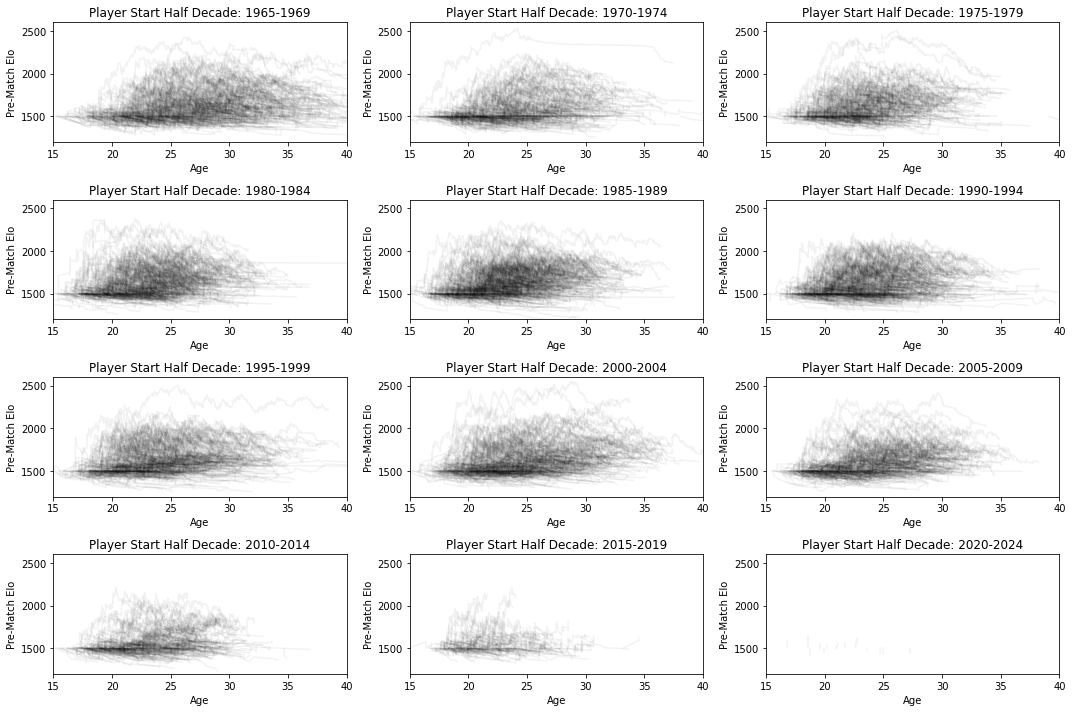

In [19]:
def p(y,loc):
  plt.subplot(4, 3, loc)
  for id in list(mins[mins["start_half_decade"]==y]['id']):
    player = all[all["id"]==id].sort_values(by="MatchEloID").set_index("age")
    plt.plot(player["PreMatchElo"],c="black",alpha=0.05)
  plt.xlim(15,40)
  plt.ylim(1200,2600)
  plt.title("Player Start Half Decade: "+str(int(y))+"-"+str(int(y+4)))
  plt.xlabel("Age")
  plt.ylabel("Pre-Match Elo")
  plt.xticks(rotation=0)
  
plt.figure(figsize=(15,10))
for i,j in enumerate(range(1965,2025,5)):
  p(float(j),loc=i+1)

plt.tight_layout()
plt.show()

Let's take another view. Let's look at average Elo ratings by age and by year. We'll also look at a similar comparision for ATP ranking. We see here that indeed 30+ players have been doing best in the 2010's, relative to young players. (See the prominent drop in the blue line.) While players age 20-24 have never dominated the game, they've done particularly bad over the last decade. This trend remains if we exlude the big 4. But recently younger players have been doing better. Note that we exclude players younger than 20 since they are often much lower ranked / rated. 

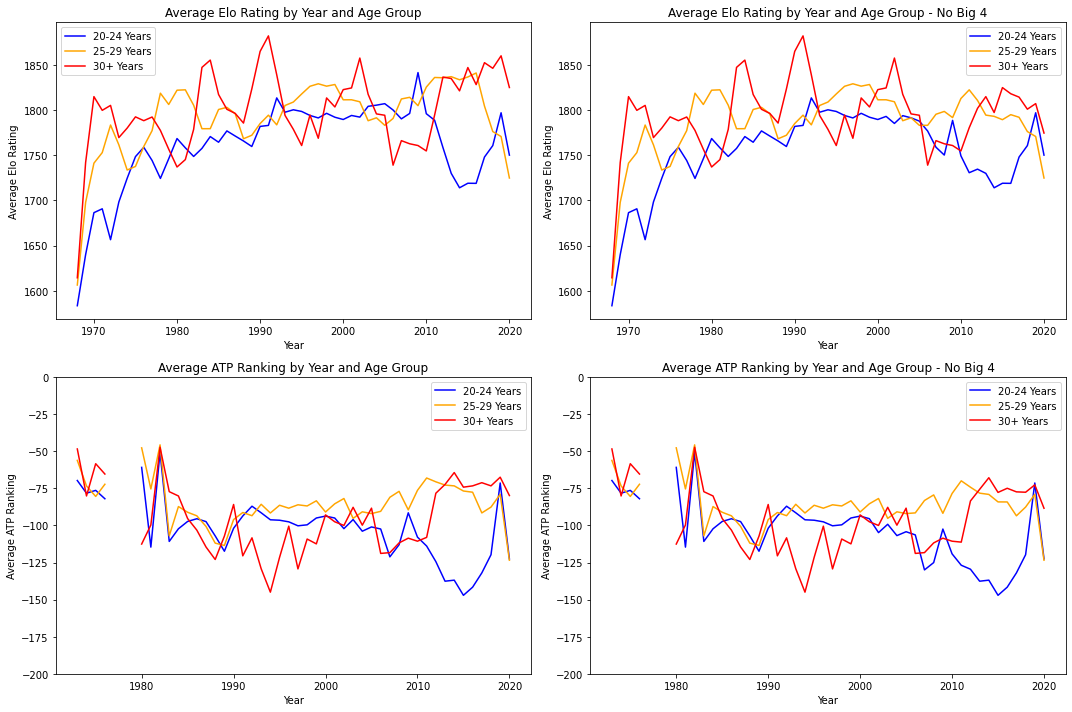

In [20]:
all["age_group"] = np.floor((all["age"]-15)/5)*5 + 15
all["age_group"] = np.where(all["age_group"]>=30,30,all["age_group"])

limited = all[(all["name"] != "Roger Federer") & 
              (all["name"] != "Rafael Nadal") & 
              (all["name"] != "Novak Djokovic") & 
              (all["name"] != "Andy Murray")]

def p(dta,lim,var,type,loc):
  mean = pd.DataFrame(dta.groupby(['year','age_group'])[[var]].agg('mean'))

  mean.reset_index(inplace=True)  
  if var=="rank":
    mean["rank"] = -mean["rank"]
  mean = mean.pivot(index='year',columns='age_group')[[var]]
  mean.reset_index(inplace=True) 
  mean.columns = mean.columns.get_level_values(1)

  plt.subplot(2, 2, loc)
  plt.plot(mean[""],mean[20.0],label="20-24 Years",c="blue")
  plt.plot(mean[""],mean[25.0],label="25-29 Years",c="orange")
  plt.plot(mean[""],mean[30.0],label="30+ Years",c="red")
  plt.legend()
  
  if lim=="lim":
    plt.title("Average "+type+" by Year and Age Group - No Big 4")
  else:
    plt.title("Average "+type+" by Year and Age Group")
  plt.xlabel("Year")
  plt.ylabel("Average "+type)
  if var=="rank":
    plt.ylim(-200,0)

plt.figure(figsize=(15,10))
p(all,"all","PreMatchElo","Elo Rating",loc=1)
p(limited,"lim","PreMatchElo","Elo Rating",loc=2)
p(all,"all","rank","ATP Ranking",loc=3)
p(limited,"lim","rank","ATP Ranking",loc=4)
plt.tight_layout()
plt.show()


Finally, we'll look at the average age for players that hit the top 10 by year. We see that the average age of top 10 players did jump in the 2010's and that this has persisted. However, we see that when we remove the big 4, the trend exists in the early 2010's but then drops away in more recent years. 

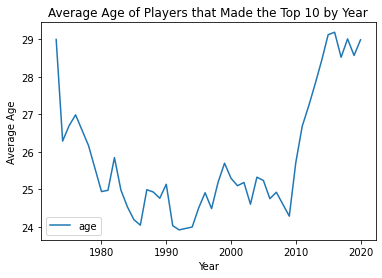

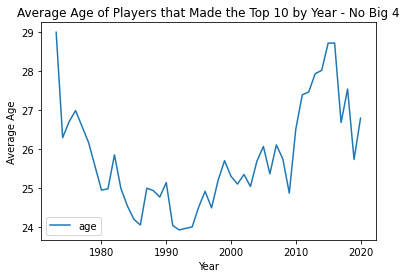

In [21]:
pd.DataFrame(all[all["rank"]<=10].groupby(['year'])[["age"]].agg('mean')).plot()
plt.title("Average Age of Players that Made the Top 10 by Year")
plt.xlabel("Year")
plt.ylabel("Average Age")
plt.show()

pd.DataFrame(limited[limited["rank"]<=10].groupby(['year'])[["age"]].agg('mean')).plot()
plt.title("Average Age of Players that Made the Top 10 by Year - No Big 4")
plt.xlabel("Year")
plt.ylabel("Average Age")
plt.show()

All told, there is pretty convincing evidence that in the 2010 there was a dearth of high performing young players. The top 10 was filled with older players and older players has higher Elo ratings and ATP rankings on average. This trend has been falling away in more recent years. 

**Number of Matches**

Next, I check which players appear for the highest number of matches. We see that Jimmy Conors has played the most matches at 1,573, followed by Roger Federer. This makes sense when you consider that both had their first wins at age 17 and his latest win was at age 42 and 38. There are other players with impressive lengths of careers but Jimmy and Roger are in a league of their own. Most players play many fewer matched and have much shorter durations between their first and last win. 


In [32]:
losers = matches[["loser_id","loser_name"]]
losers = losers.rename(columns={"loser_id": "id", "loser_name": "name"})

winners = matches[["winner_id","winner_name"]]
winners = winners.rename(columns={"winner_id": "id", "winner_name": "name"})

players = pd.concat([losers,winners])
players = players.groupby(['id','name']).size().reset_index().rename(columns={0:'count'})

players.sort_values("count",ascending=False)[0:5]

,id,name,count
279,100284,Jimmy Connors,1547
2285,103819,Roger Federer,1507
616,100656,Ivan Lendl,1314
277,100282,Guillermo Vilas,1232
2680,104745,Rafael Nadal,1187


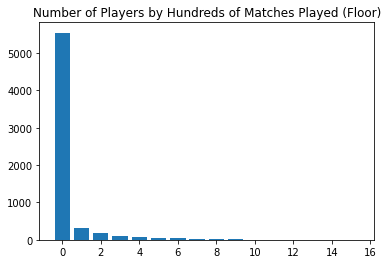

In [33]:
simple_count = np.floor(players["count"]/100)
x = Counter(simple_count)
plt.bar(x.keys(), x.values())
plt.title("Number of Players by Hundreds of Matches Played (Floor)")
plt.show()

In [35]:
def MinMaxAge(name):
  print(name,"Min Win Age: ",matches[(matches["winner_name"]==name)]["winner_age"].min())
  print(name,"Max Win Age: ",matches[(matches["winner_name"]==name)]["winner_age"].max())
  
MinMaxAge("Jimmy Connors")
MinMaxAge("Roger Federer")

Jimmy Connors Min Win Age:  17.954825462
Jimmy Connors Max Win Age:  42.7926078029
Roger Federer Min Win Age:  17.138945927400002
Roger Federer Max Win Age:  38.450376454499995


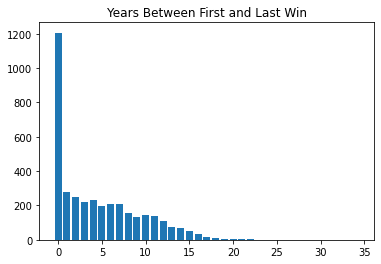

In [36]:
MinMaxAgesData = matches.groupby(['winner_name'])['year'].agg(['min','max']).reset_index()
MinMaxAgesData["years_between_wins"] = np.round(MinMaxAgesData["max"] - MinMaxAgesData["min"])
x = Counter(MinMaxAgesData["years_between_wins"])
plt.bar(x.keys(), x.values())
plt.title("Years Between First and Last Win")
plt.show()